Installing required libraries

In [1]:
!pip install transformers
!pip install datasets

In [2]:
import pandas as pd
import torch

# Import dataset

We will be using emotion dataset from hugging face which has a collection of text as inputs and is cateogorized into 6 labels.

sadness', 'joy', 'love', 'anger', 'fear', 'surprise'

In [3]:
#Load dataset
from datasets import load_dataset
emotions = load_dataset("emotion")

In [4]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

# Data Exploration

Lets start understanding the data by exploring it.

In [5]:
#Looking at only the training example

train_ds = emotions['train']

In [6]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


There are 6 labels in the dataset. sadness', 'joy', 'love', 'anger', 'fear', 'surprise'

In [8]:
# Change the dataset type ot pandas to explore the dataset as a dataframe

emotions.set_format(type="pandas")


In [9]:
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [10]:
# Map the label names to the labels

def label_to_str(row):
  return emotions['train'].features['label'].int2str(row)

df["label_name"] = df['label'].apply(label_to_str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


# Visual analytics to explore the data
Lets try to understand the distribution of the labels.

<Axes: >

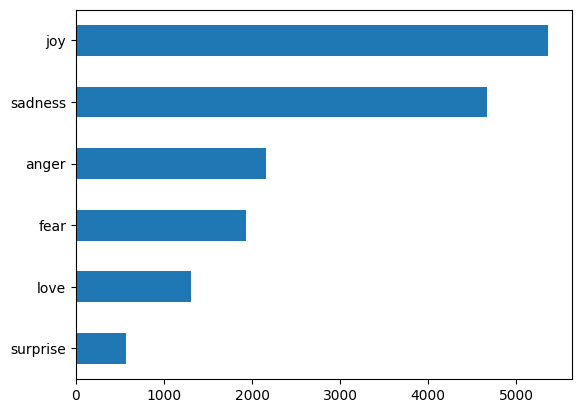

In [11]:
# Label distribution

df['label_name'].value_counts(ascending=True).plot.barh()


The dataset is highly imbalanced. As number of examples for the Joy category is a lot more than surprise category.

<Axes: title={'center': 'words_per_tweet'}, xlabel='label_name'>

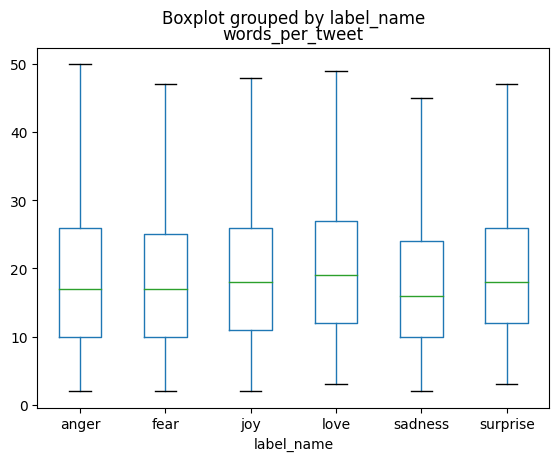

In [12]:
# How long are the tweets?

df["words_per_tweet"] = df["text"].str.split().apply(len)
df.boxplot('words_per_tweet', by="label_name", grid=False,
          showfliers=False)

In [13]:
emotions.reset_format()

# Tokenization

Lets prepare the dataset for machine learning by first tokenizing the data. We will use the same tokenizer as the distilbert model

In [14]:
from transformers import AutoTokenizer
model_cpkt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_cpkt)

In [15]:
tokenizer.model_max_length

512

In [16]:
def tokenize(batch):
  return tokenizer(batch['text'], padding=True, truncation=True)

In [17]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [18]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [19]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


# Option 1: Transformers as feature extractors
Using transformers to create word embeddings and the feeding those word embeddings to a classification model for classification

In [20]:
# Load model Distilbert

from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [21]:
# Example of tokenization.

text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
print(inputs)

Input tensor shape: torch.Size([1, 6])
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


In [22]:
# Put the model and the tokens on the same device

inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [23]:
# Extracting the last hidden state.

outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [24]:
# Applying it all together to create word embeddings for input text.

def extract_hidden_states(batch):
  # Place model inputs on the GPU
  inputs = {k:v.to(device) for k,v in batch.items() if k in tokenizer.model_input_names}
  #extract last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state
  #return vector for [CLS] token
  return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [25]:
emotions_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])

In [26]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [27]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [28]:
# Creating training and validation set

import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [29]:
# Using a simple logistic regression model for classification

from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.633

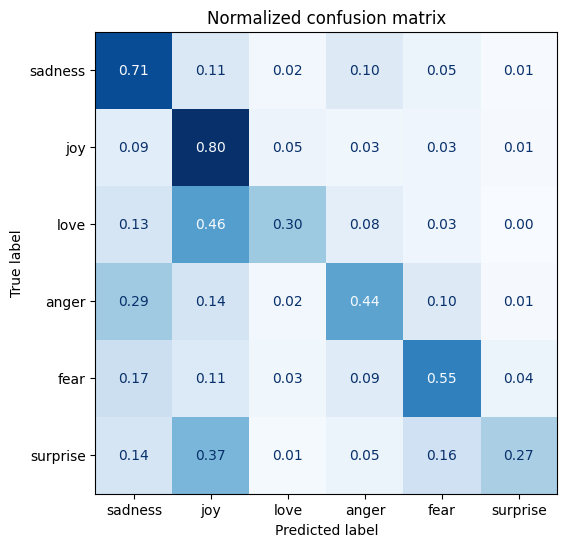

In [30]:
#Lets also look at the kind of errors our model made

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt


labels = emotions["train"].features["label"].names

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

# Option 2: Fine tuning Transfomers

Here we will finetune the basemodel for the classification task instead of using it as a feature extractor.

In [31]:
# Loading the model

from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [33]:
from huggingface_hub import notebook_login

notebook_login()

In [37]:
! pip install transformers[torch]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.5 MB/s eta 0:00:00


In [34]:
# Using Huggingface trainer to finetune the model on the classification task

from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True,
                                  log_level="error")


from transformers import Trainer

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.848100,0.332048,0.901500,0.899710
2,0.254900,0.224763,0.922500,0.922604


In [35]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [36]:
preds_output.metrics

{'test_loss': 0.22476327419281006,
 'test_accuracy': 0.9225,
 'test_f1': 0.9226043260338767,
 'test_runtime': 4.1352,
 'test_samples_per_second': 483.657,
 'test_steps_per_second': 7.739}

In [37]:
y_preds = np.argmax(preds_output.predictions, axis=1)

As you can see this model performs significantly better than using Transformer as a feature extractor

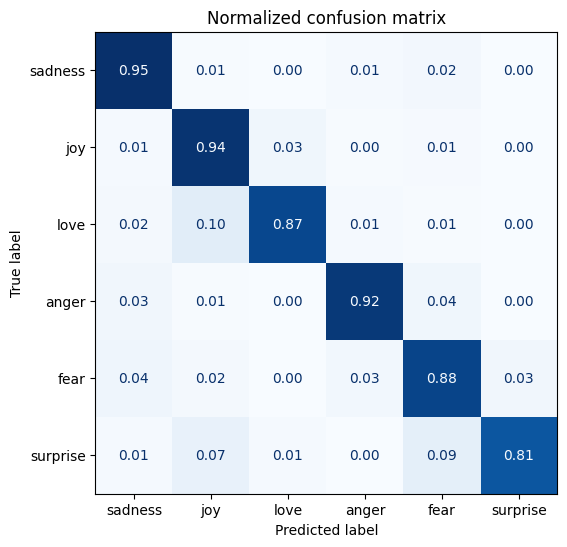

In [38]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [39]:
# Lets test out the model

In [40]:
from transformers import pipeline

# Change `transformersbook` to your Hub username
model_id = "hrangi/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

custom_tweet = "I saw a movie today and it was really good."
preds = classifier(custom_tweet, return_all_scores=True)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [41]:
preds

[[{'label': 'LABEL_0', 'score': 0.018904024735093117},
  {'label': 'LABEL_1', 'score': 0.9394935965538025},
  {'label': 'LABEL_2', 'score': 0.014808285981416702},
  {'label': 'LABEL_3', 'score': 0.01058170199394226},
  {'label': 'LABEL_4', 'score': 0.007334284018725157},
  {'label': 'LABEL_5', 'score': 0.008878014050424099}]]

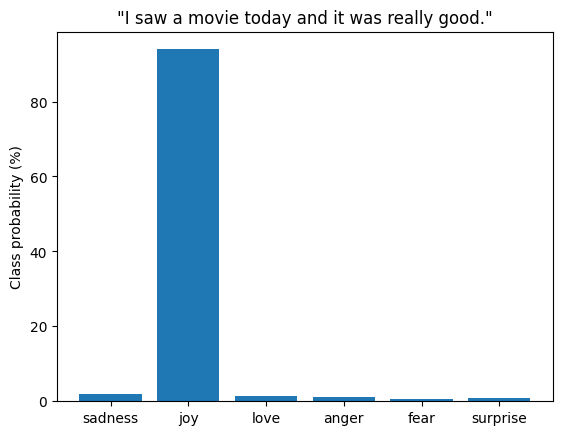

In [42]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()